# Import Data

In [1]:
import pandas as pd

data = pd.read_csv("final_merged_15.csv", index_col=0)
data = data.drop(columns=["MP_diff(y)"])
len(data)

247500

# Deal with Null values

In [2]:
print(data.isna().sum())

TCAS_std           0
TCAS_mean          0
TCAS_close         0
TCAS_delta         0
TCAS_corr          0
TCBS_std           0
TCBS_mean          0
TCBS_close         0
TCBS_delta         0
TCBS_corr          0
ALPHA_std          0
ALPHA_mean         0
ALPHA_close        0
ALPHA_delta        0
ALPHA_corr         0
BETA_std           0
BETA_mean          0
BETA_close         0
BETA_delta         0
BETA_corr          0
ZETA_std           0
ZETA_mean          0
ZETA_close         0
ZETA_delta         0
ZETA_corr          0
WMP_std            0
WMP_delta       4026
WMP_corr       85815
AWS_std            0
AWS_mean           0
AWS_close       2022
AWS_delta       4026
AWS_corr       85815
VOL_std            0
VOL_mean           0
VOL_close          1
VOL_delta          6
VOL_corr         109
GAP_std            0
GAP_mean           0
GAP_close          1
GAP_delta          6
GAP_corr         109
nUoD_std           0
nUoD_mean          0
nUoD_close         1
nUoD_delta         6
nUoD_corr    

In [3]:
for feat in list(data):
    if feat.split("_")[-1] in ["close", "mean"]:
        data = data[~data[feat].isna()] # drop absolute values

data.fillna(0, inplace=True) # fill delta and corr values with 0
len(data)

245477

# EDA

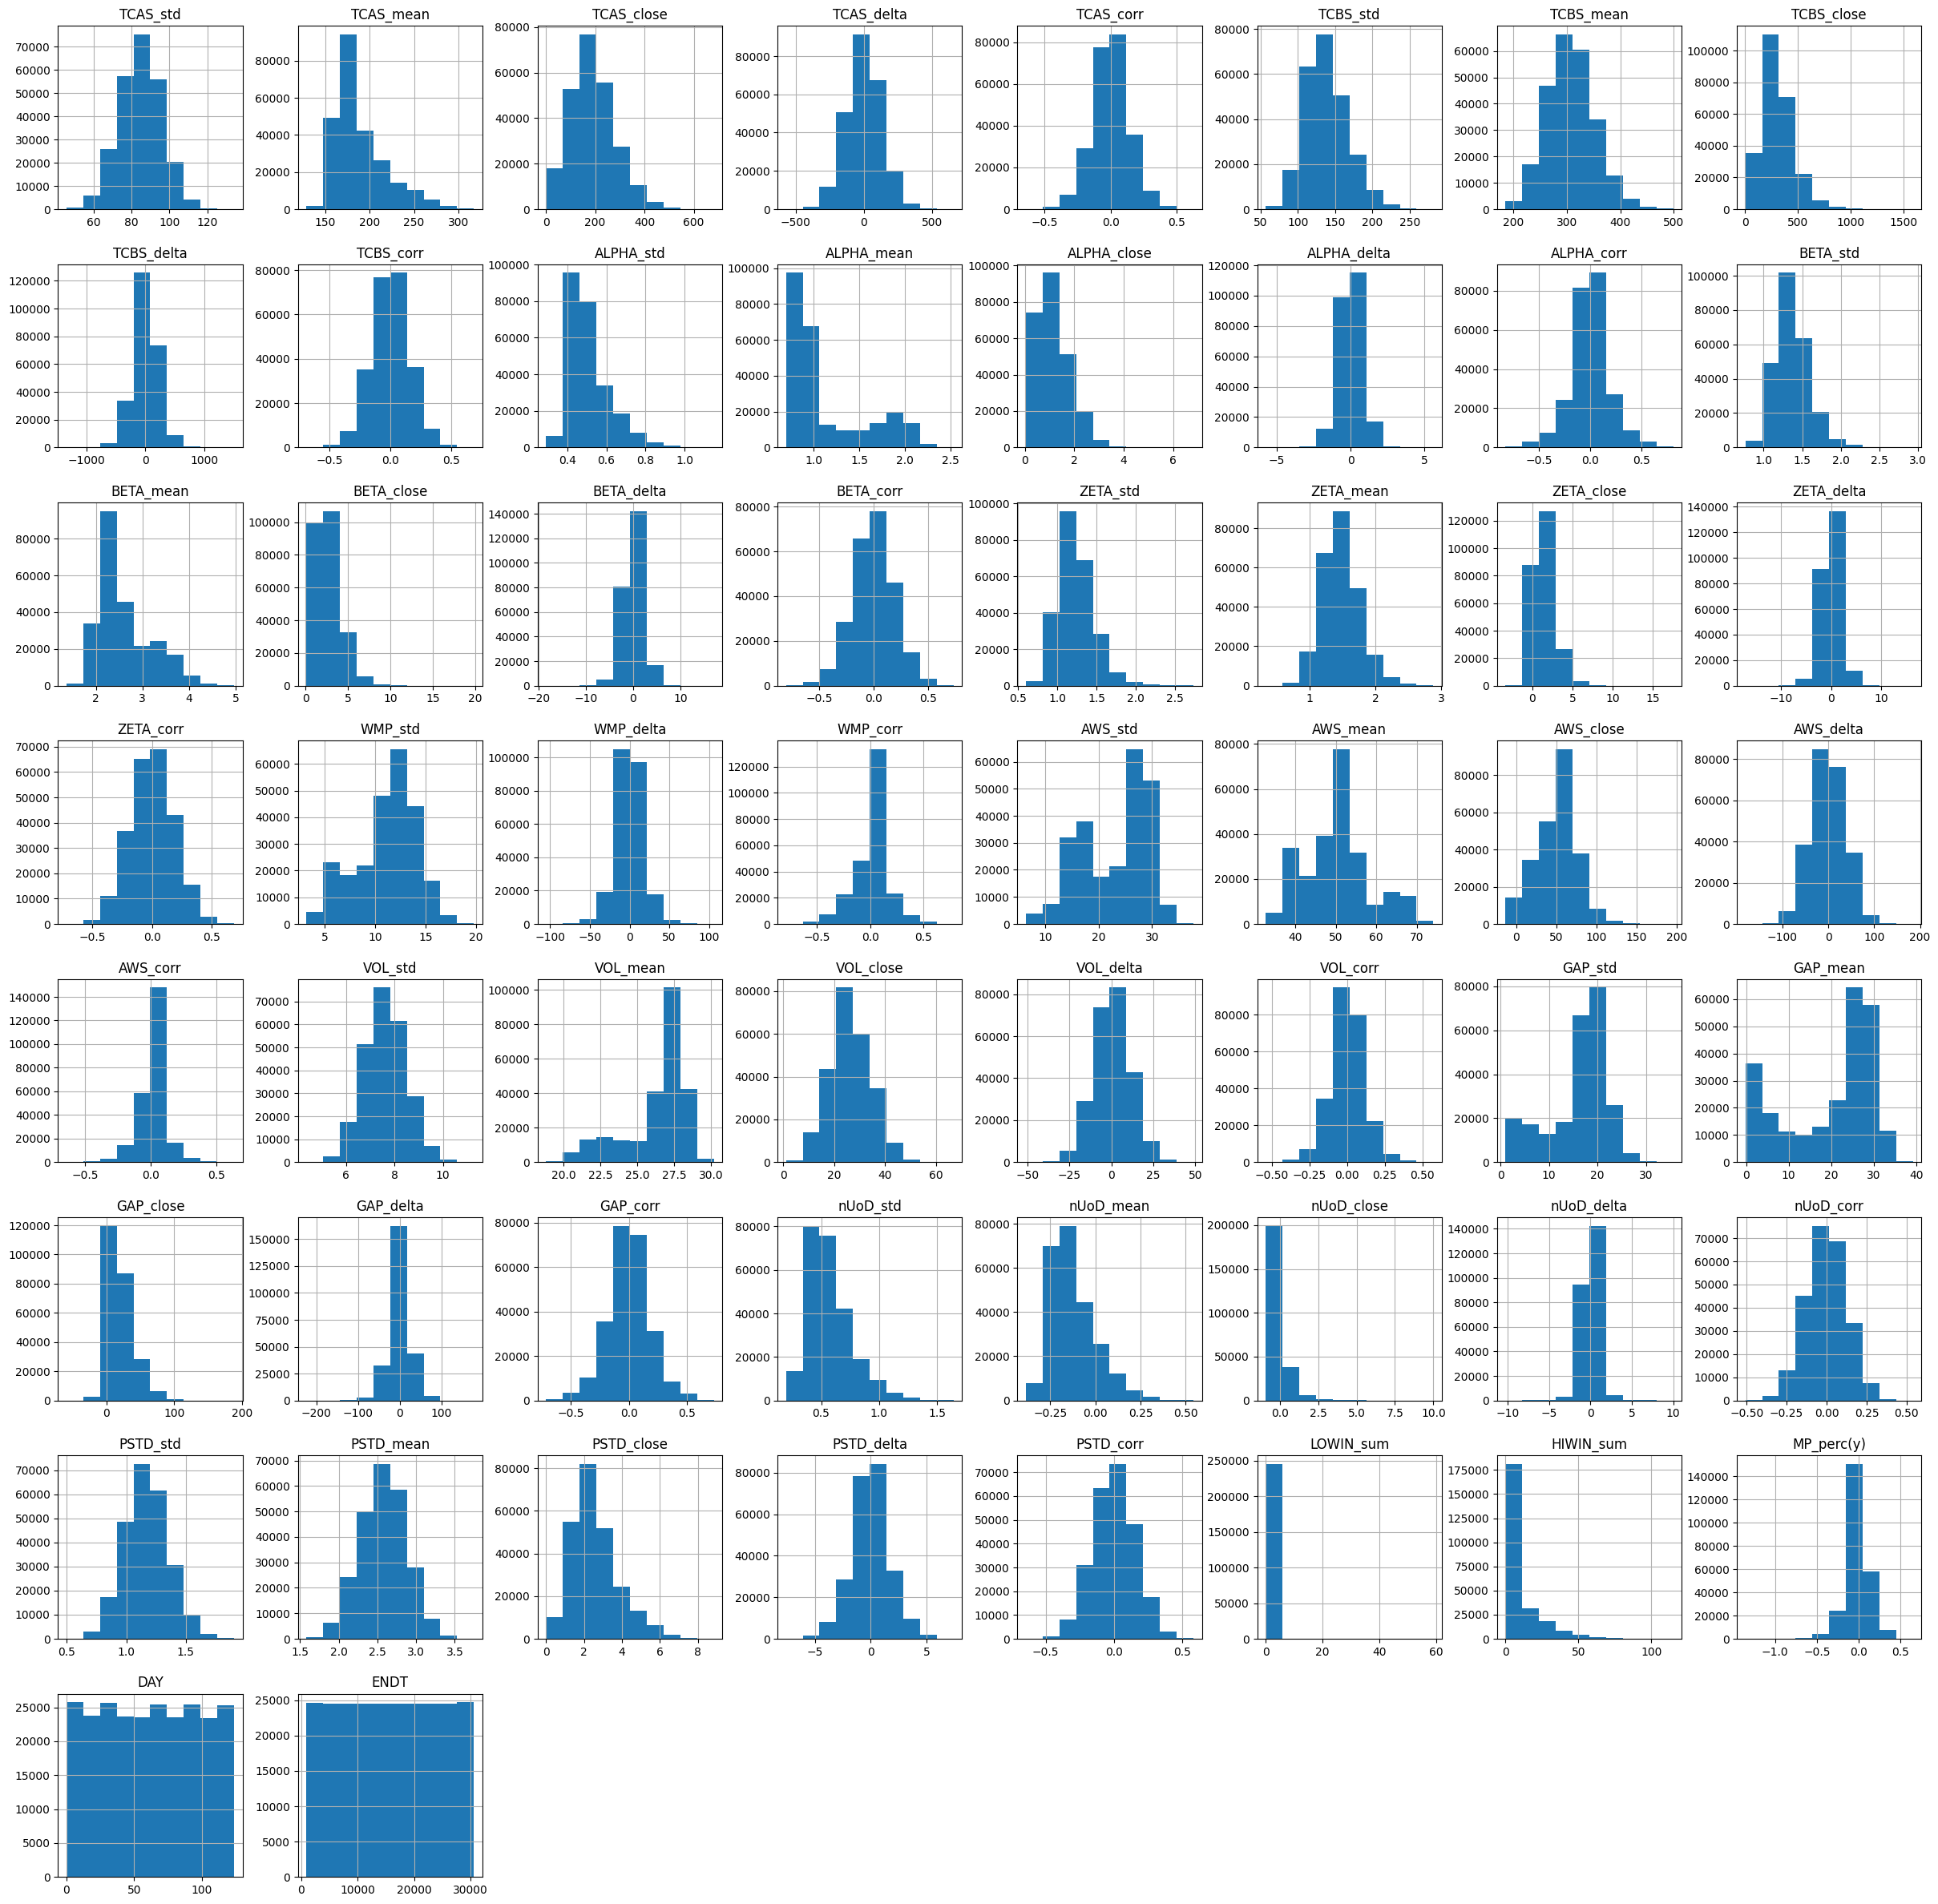

In [4]:
import matplotlib.pyplot as plt
data.hist(figsize=(30,30))
plt.show()

In [5]:
# scale features

x_features = list(data)
x_features.remove("MP_perc(y)")

# scale data between 0 and 1
for col in x_features:
    #data[col] = np.log(data[col] + data[col].min())
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

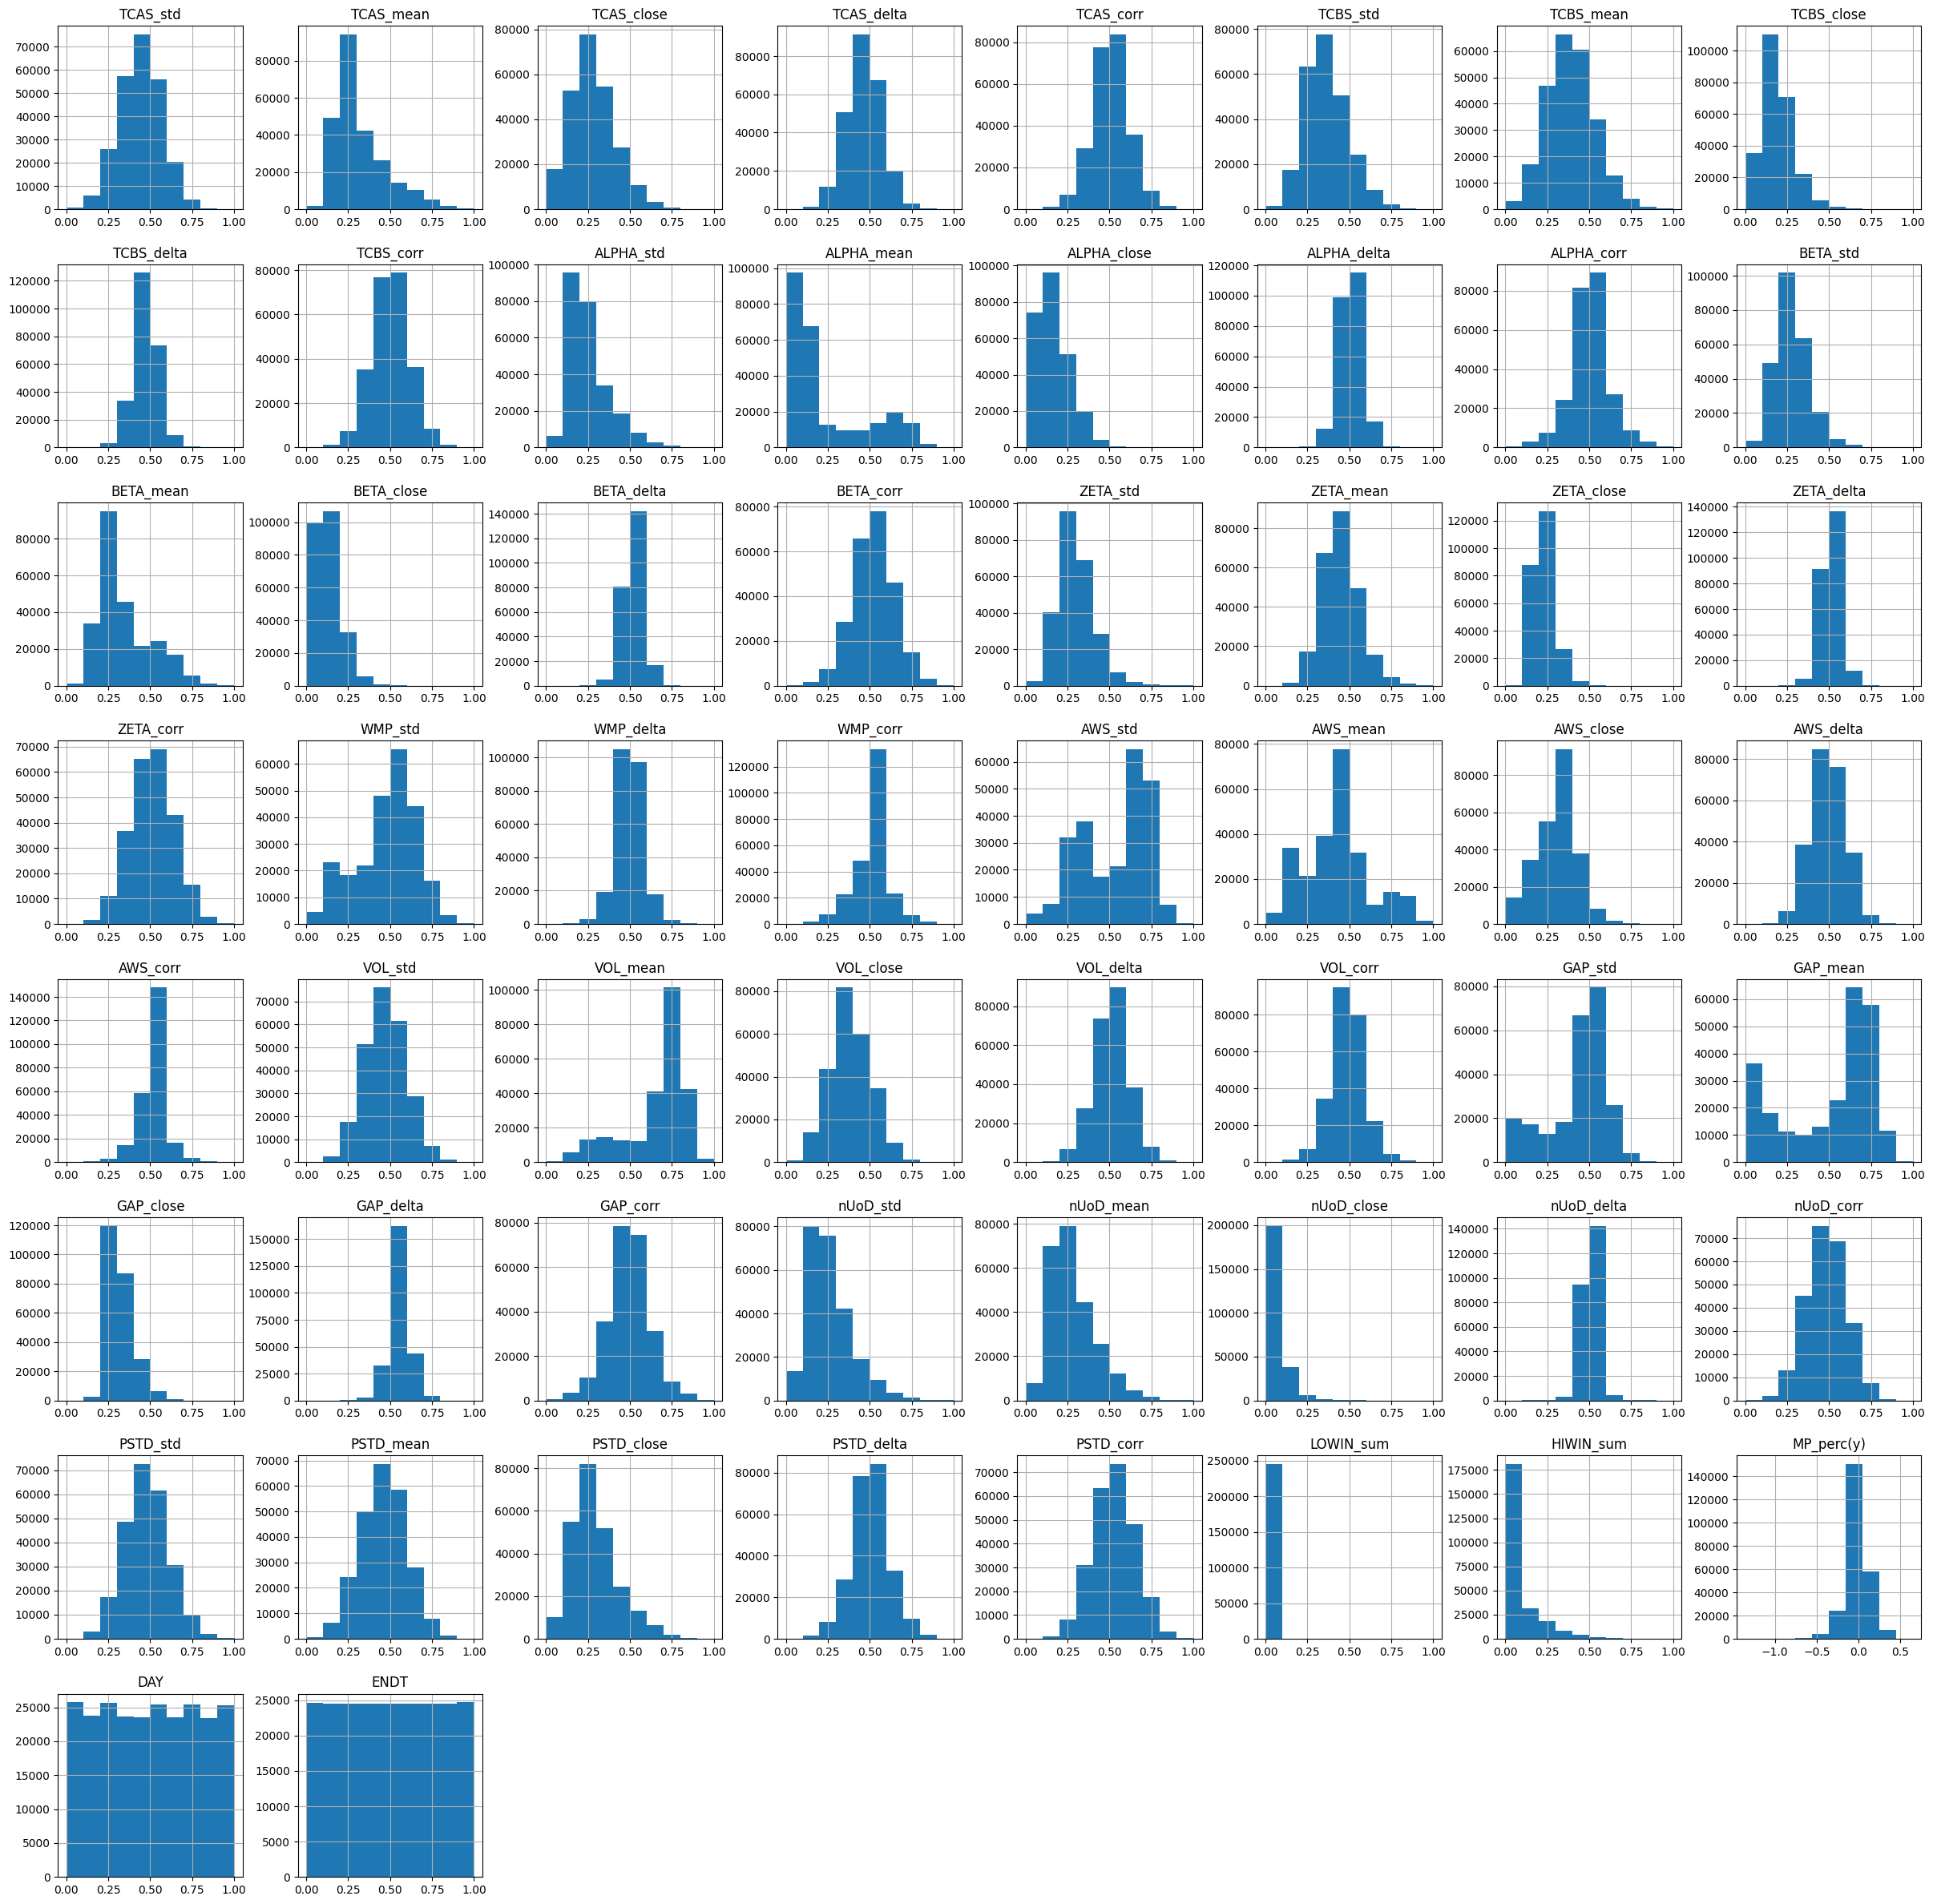

In [6]:
data.hist(figsize=(30,30))
plt.show()

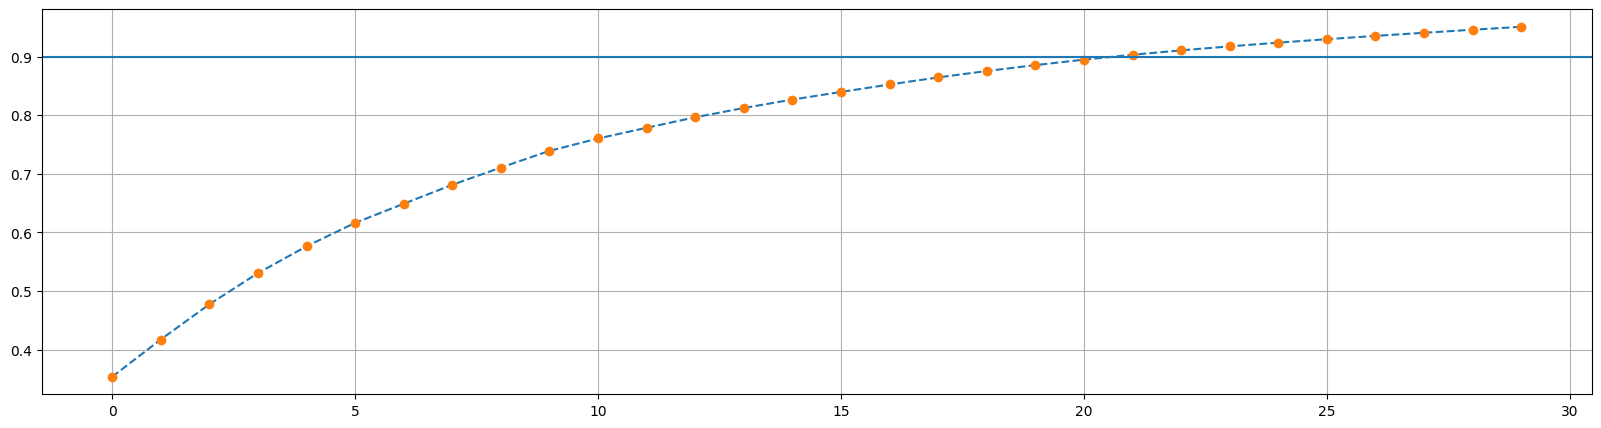

In [7]:
# apply pca
from sklearn.decomposition import PCA
import numpy as np

pca_features = x_features[:]
pca_features.remove("ENDT")
pca_features.remove("DAY")

pca = PCA(n_components=30)
pca_vectors = pca.fit_transform(data[pca_features])

plt.figure(figsize=(20,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linestyle = "--")
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o')
plt.axhline(0.9)
plt.grid()

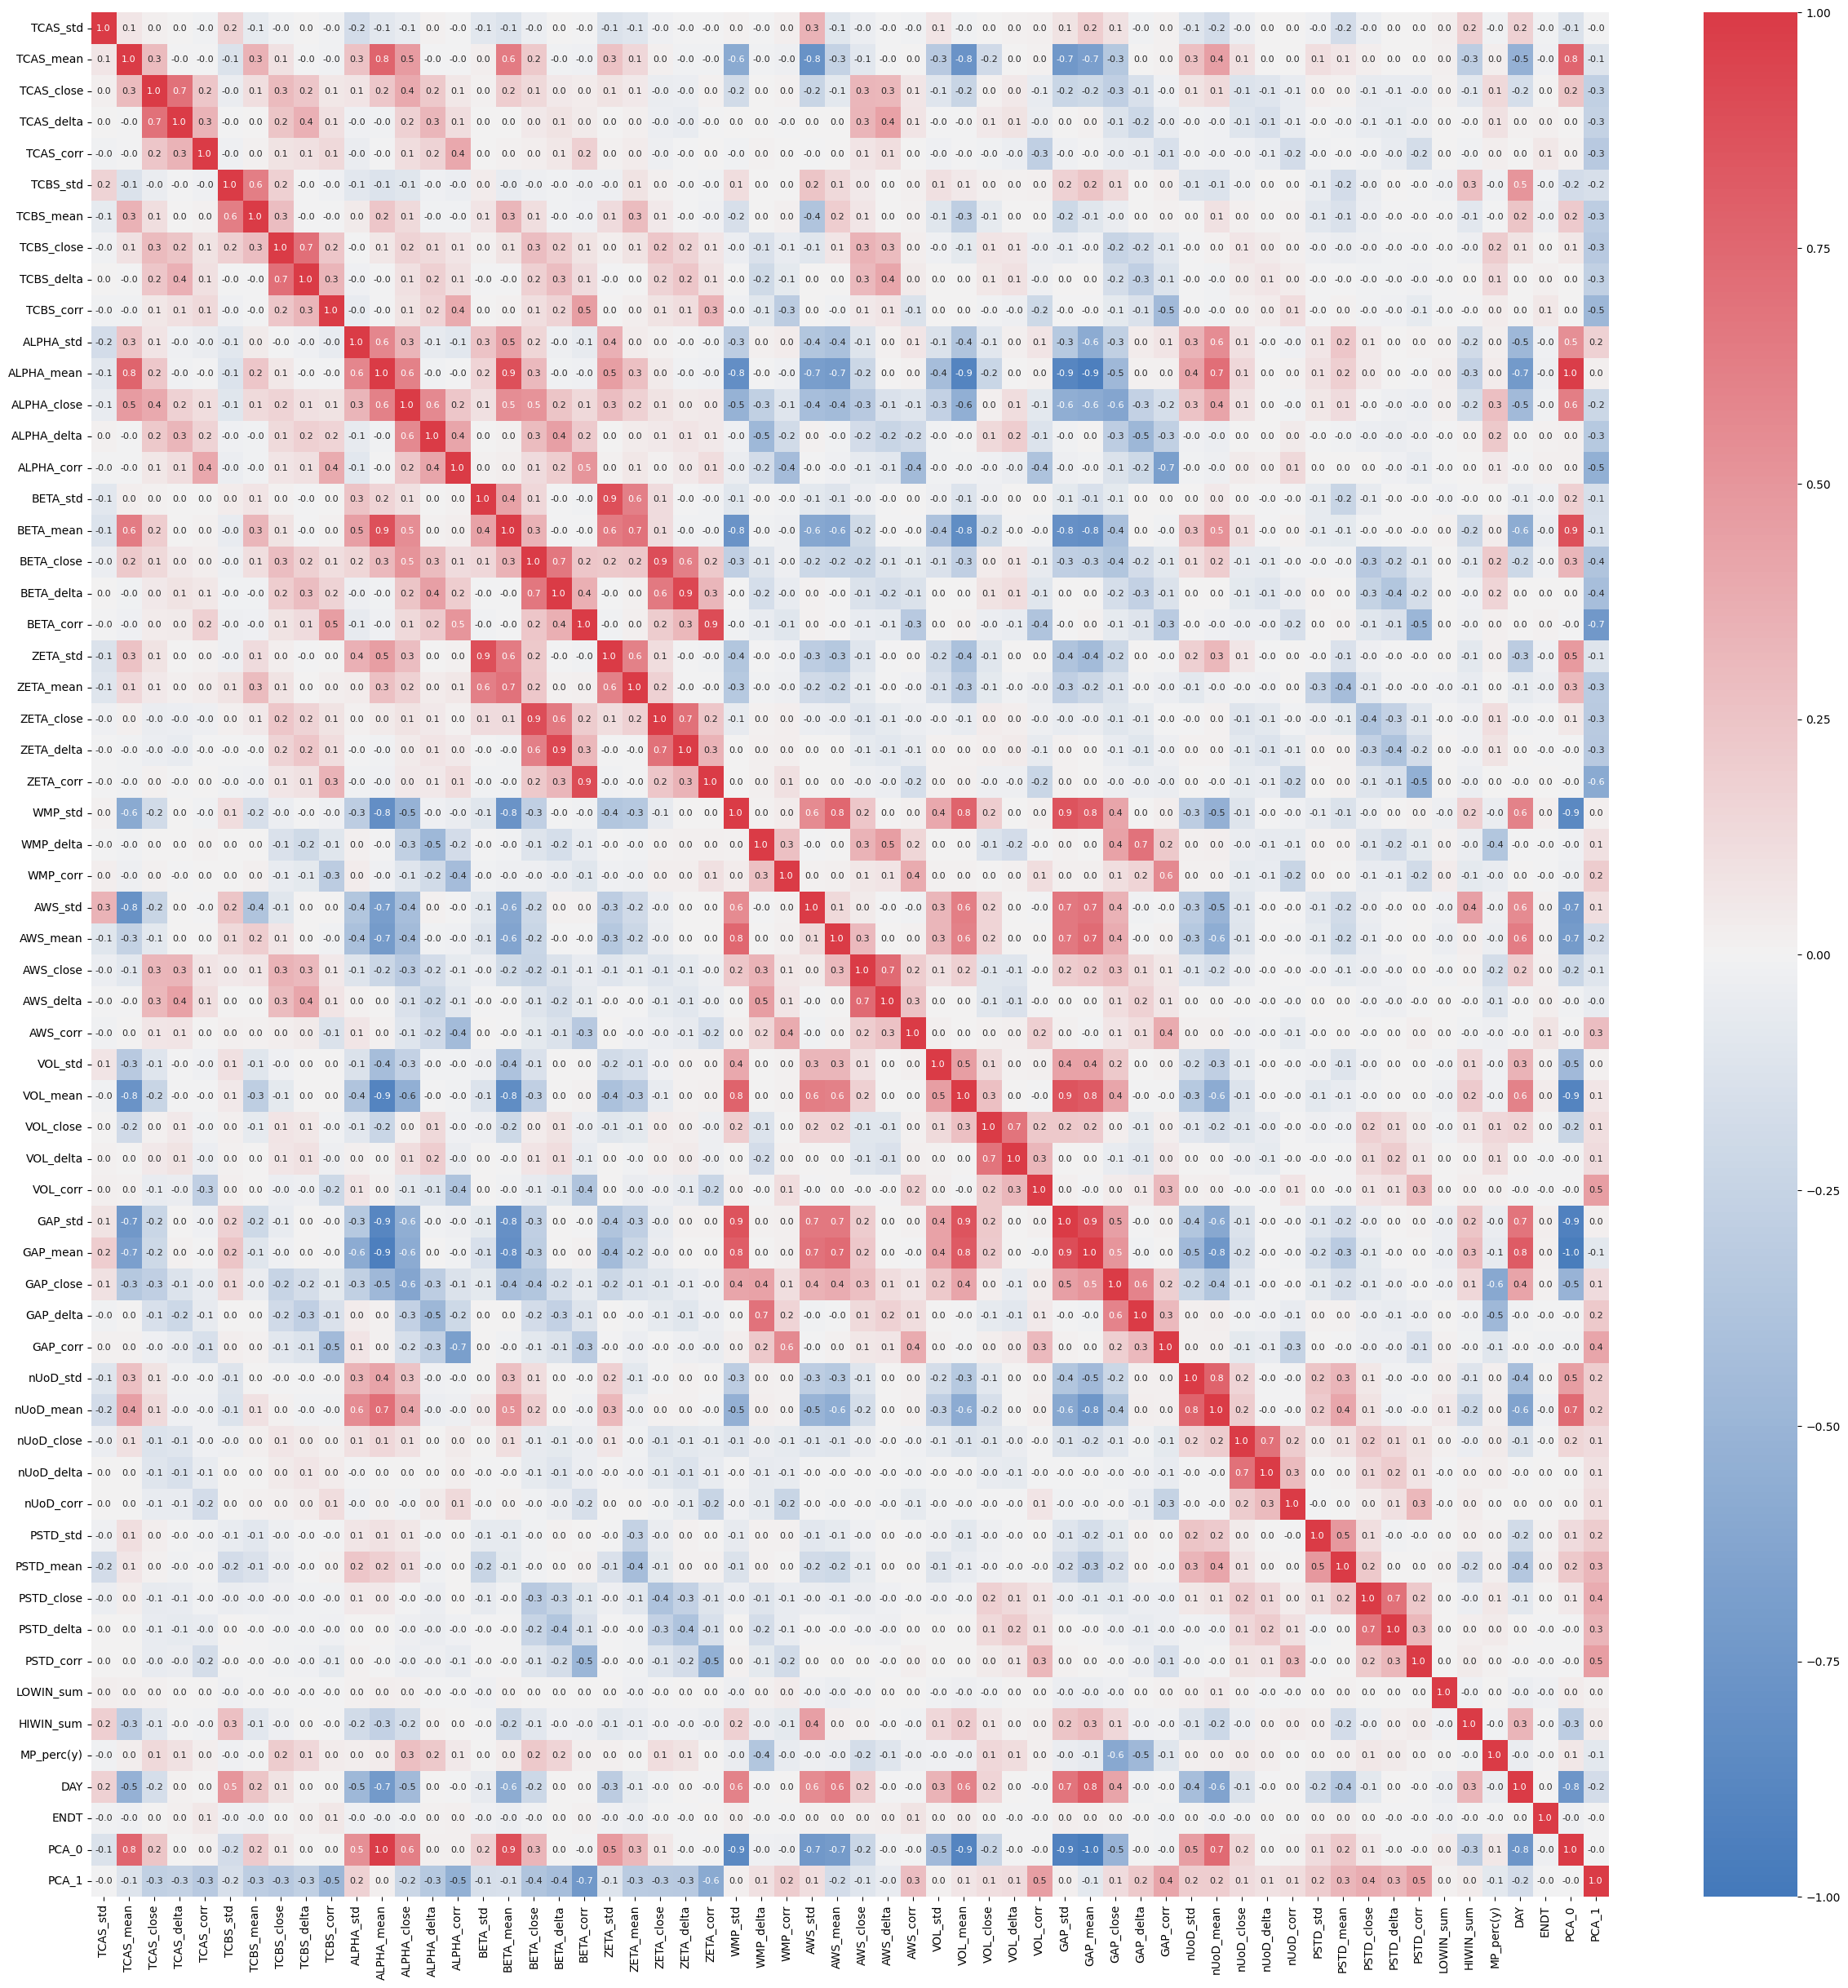

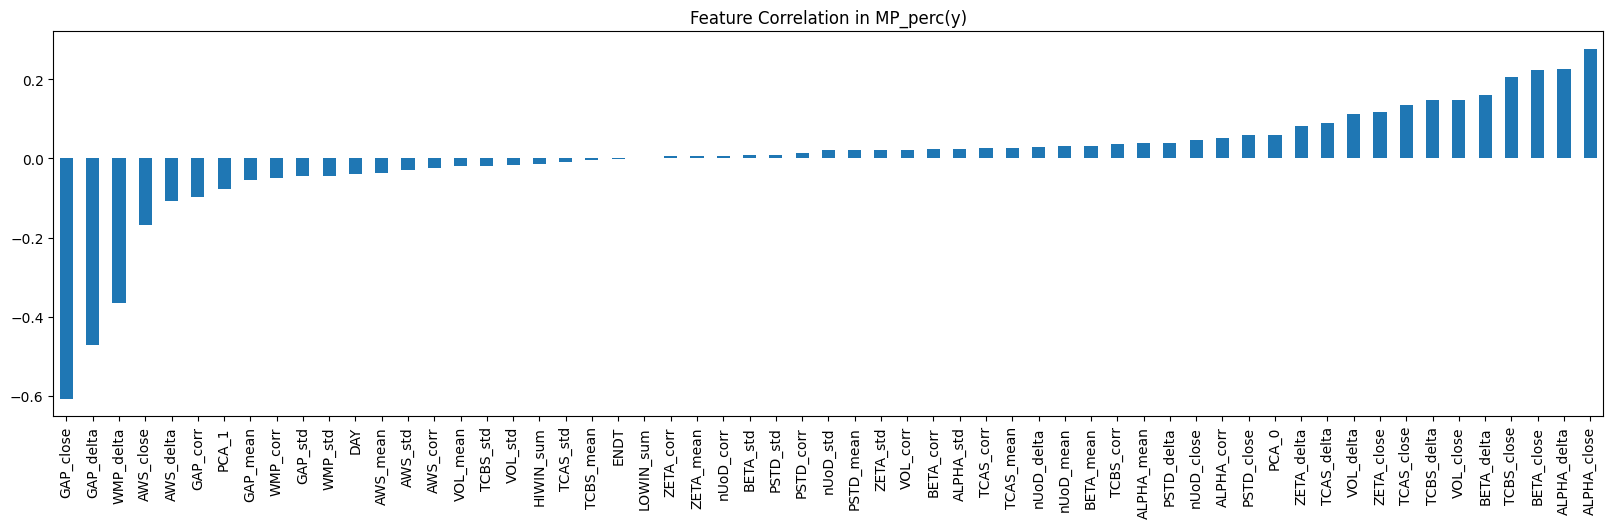

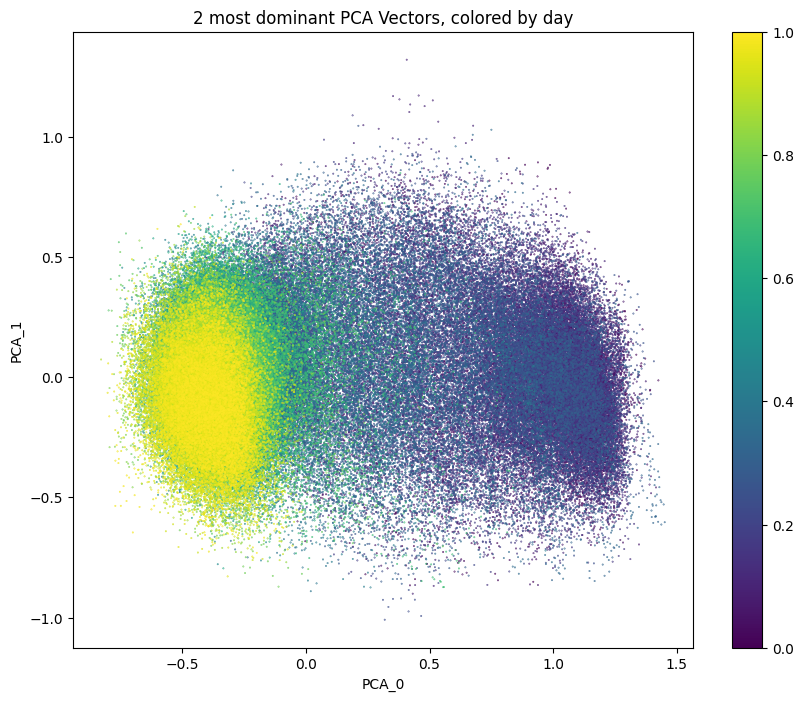

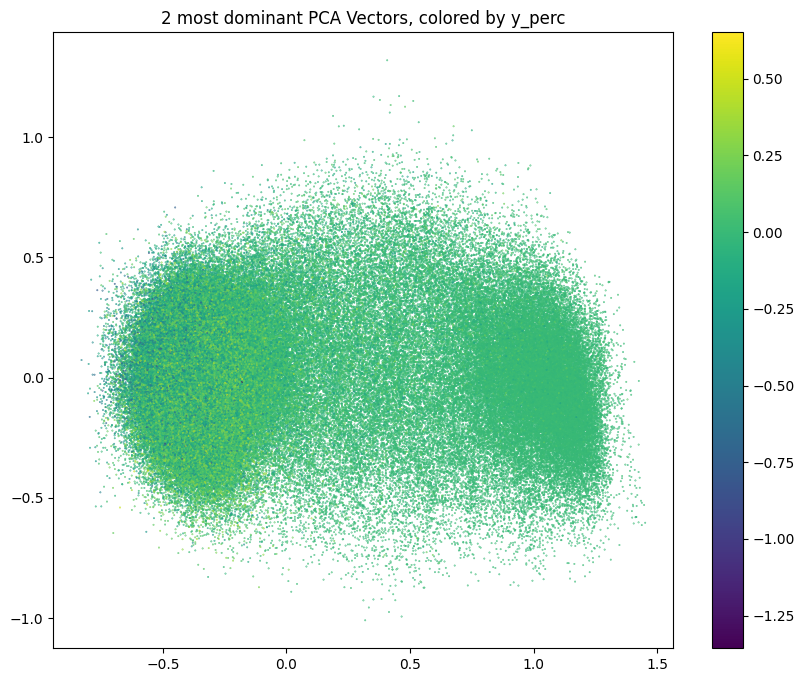

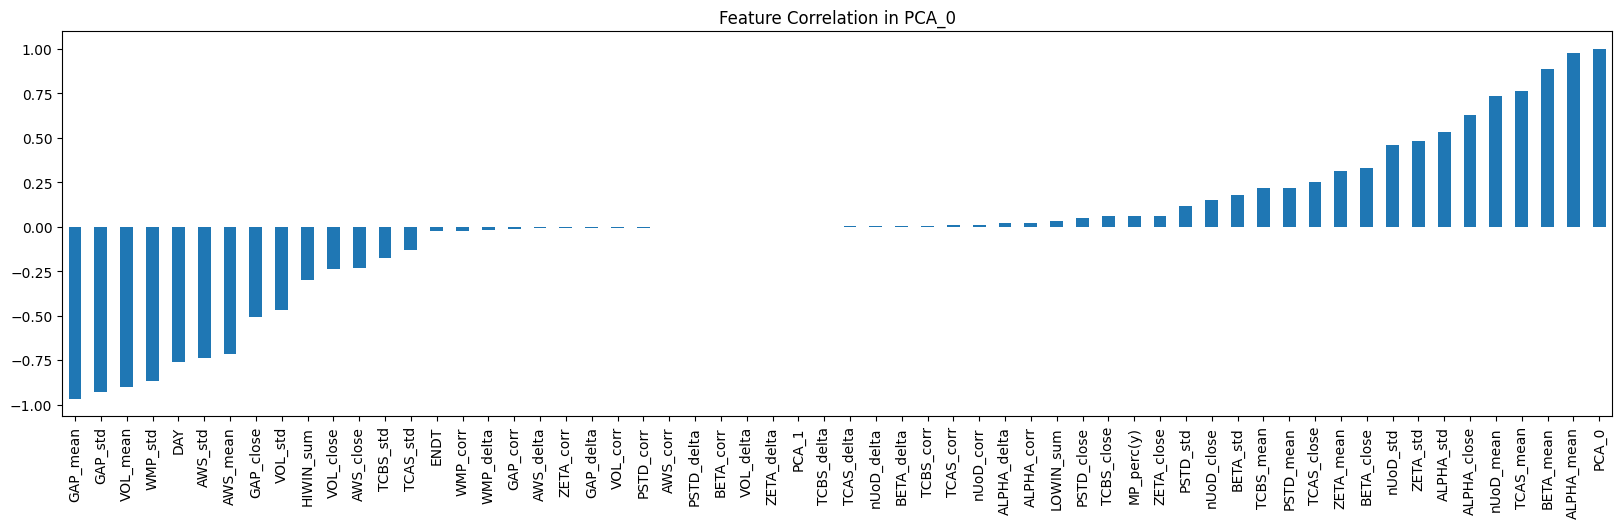

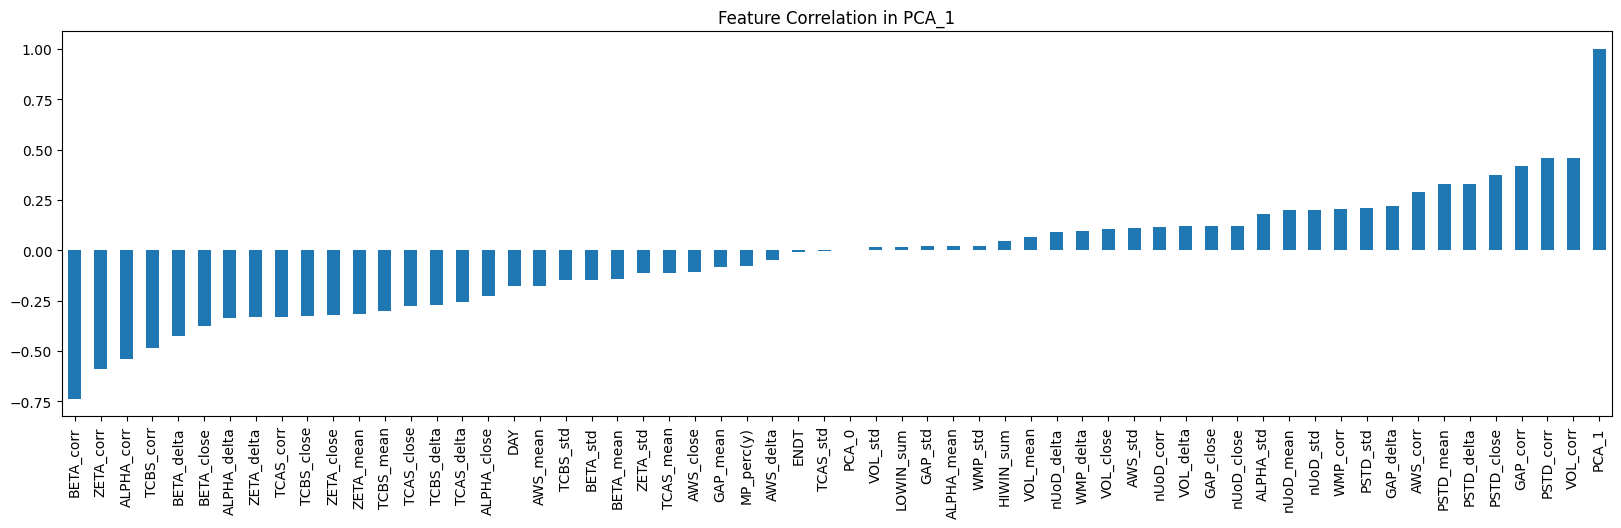

In [8]:
X = pca_vectors[:,:2]
import seaborn as sns

for i in range(X.shape[1]):
    data[f"PCA_{i}"] = X[:,i]

plt.figure(figsize=(30,30))
corr_map = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_map, vmin=-1, vmax=1, cmap=cmap, center=0, annot=True, fmt=".1f", annot_kws={"size": 8})
plt.show()

corr_map[corr_map.index != "MP_perc(y)"]["MP_perc(y)"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in MP_perc(y)")
plt.show()

plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by day")
plt.scatter(X[:,0], X[:,1], c = data["DAY"].to_numpy(), s = 1/2**3)
plt.xlabel("PCA_0")
plt.ylabel("PCA_1")
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_perc")
plt.scatter(X[:,0], X[:,1], c = data["MP_perc(y)"], s = 1/2**3)
plt.colorbar()
plt.show()

corr_map["PCA_0"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_0")
plt.show()
corr_map["PCA_1"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_1")
plt.show()

In [11]:
len(corr_map)

60

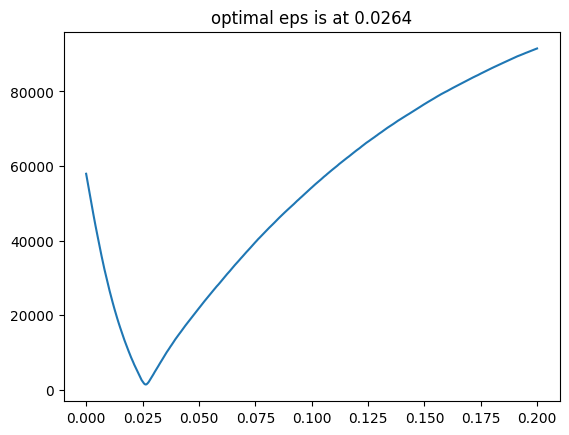

In [12]:
y_perc = data["MP_perc(y)"]

eps_vals = np.arange(0, 0.2, 0.0001)

def eps_y_bool(arr, eps):
    return np.std([np.sum(arr > eps),np.sum(arr < -eps), np.sum( (arr < eps) & (arr > -eps) )])
    
split_ratios = []
for eps in eps_vals:
    split_ratios.append(eps_y_bool(y_perc, eps))

optimal_eps = eps_vals[np.argmin(split_ratios)]
plt.title(f"optimal eps is at {optimal_eps}")
plt.plot(eps_vals, split_ratios)
plt.show()

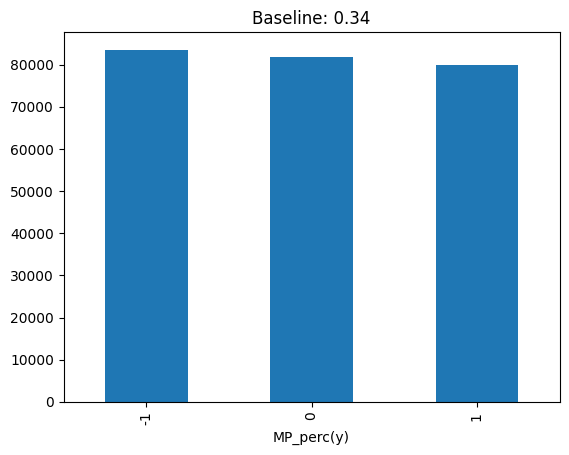

In [13]:
def gen_y_bool(y):
    if abs(y) < optimal_eps:
        return 0
    elif y > 0:
        return 1
    else:
        return -1
    
y_bool = y_perc.apply(gen_y_bool)
y_bool_splits = y_bool.value_counts()
y_bool_splits.plot(kind = "bar")
baseline = np.max(y_bool_splits) / len(data)
plt.title(f"Baseline: {baseline:.2f}")
plt.show()

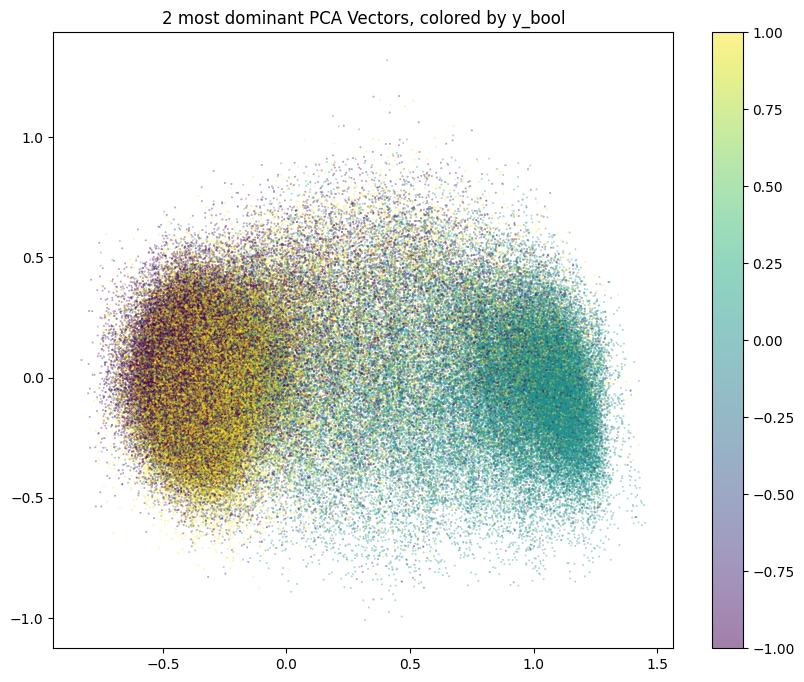

In [14]:
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_bool")
plt.scatter(X[:,0], X[:,1], c = y_bool.to_numpy(), s = 1/2**3, alpha=0.5)
plt.colorbar()
plt.show()

[ 0.09932891  0.21896221  0.21215107  0.05846165  0.00470096 -0.01620521]


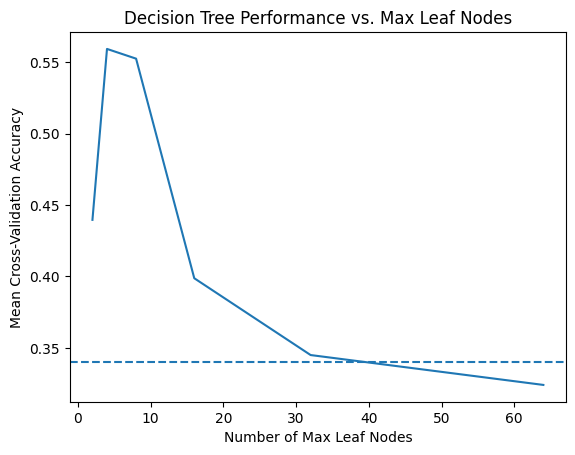

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


cv_scores = []
tree_nodes = [2,4,8,16,32,64]

mask = y_bool != 0

for n in tree_nodes:
    clf = DecisionTreeClassifier(max_leaf_nodes=n)
    scores = cross_val_score(clf, data[x_features], y_bool, cv=5)  # Assuming you have data X and labels y
    cv_scores.append(scores.mean())

print(cv_scores - baseline)
plt.plot(tree_nodes, cv_scores)
plt.xlabel('Number of Max Leaf Nodes')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Decision Tree Performance vs. Max Leaf Nodes')
plt.axhline(baseline, linestyle = "--")
plt.show()

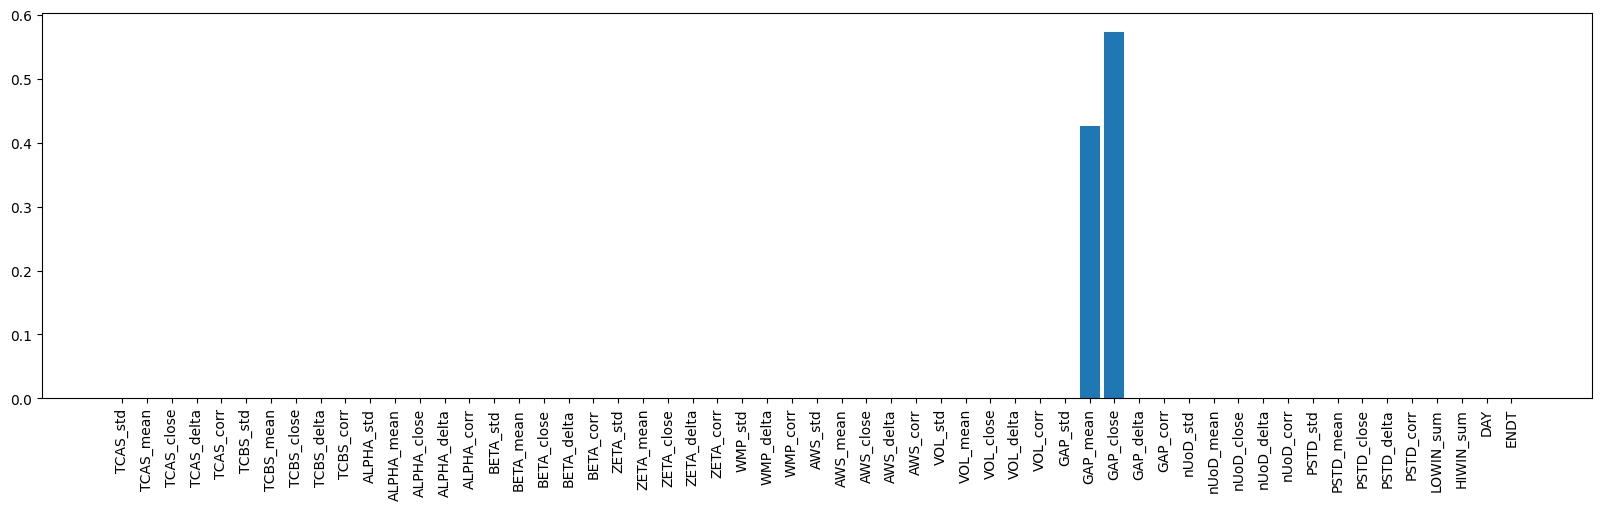

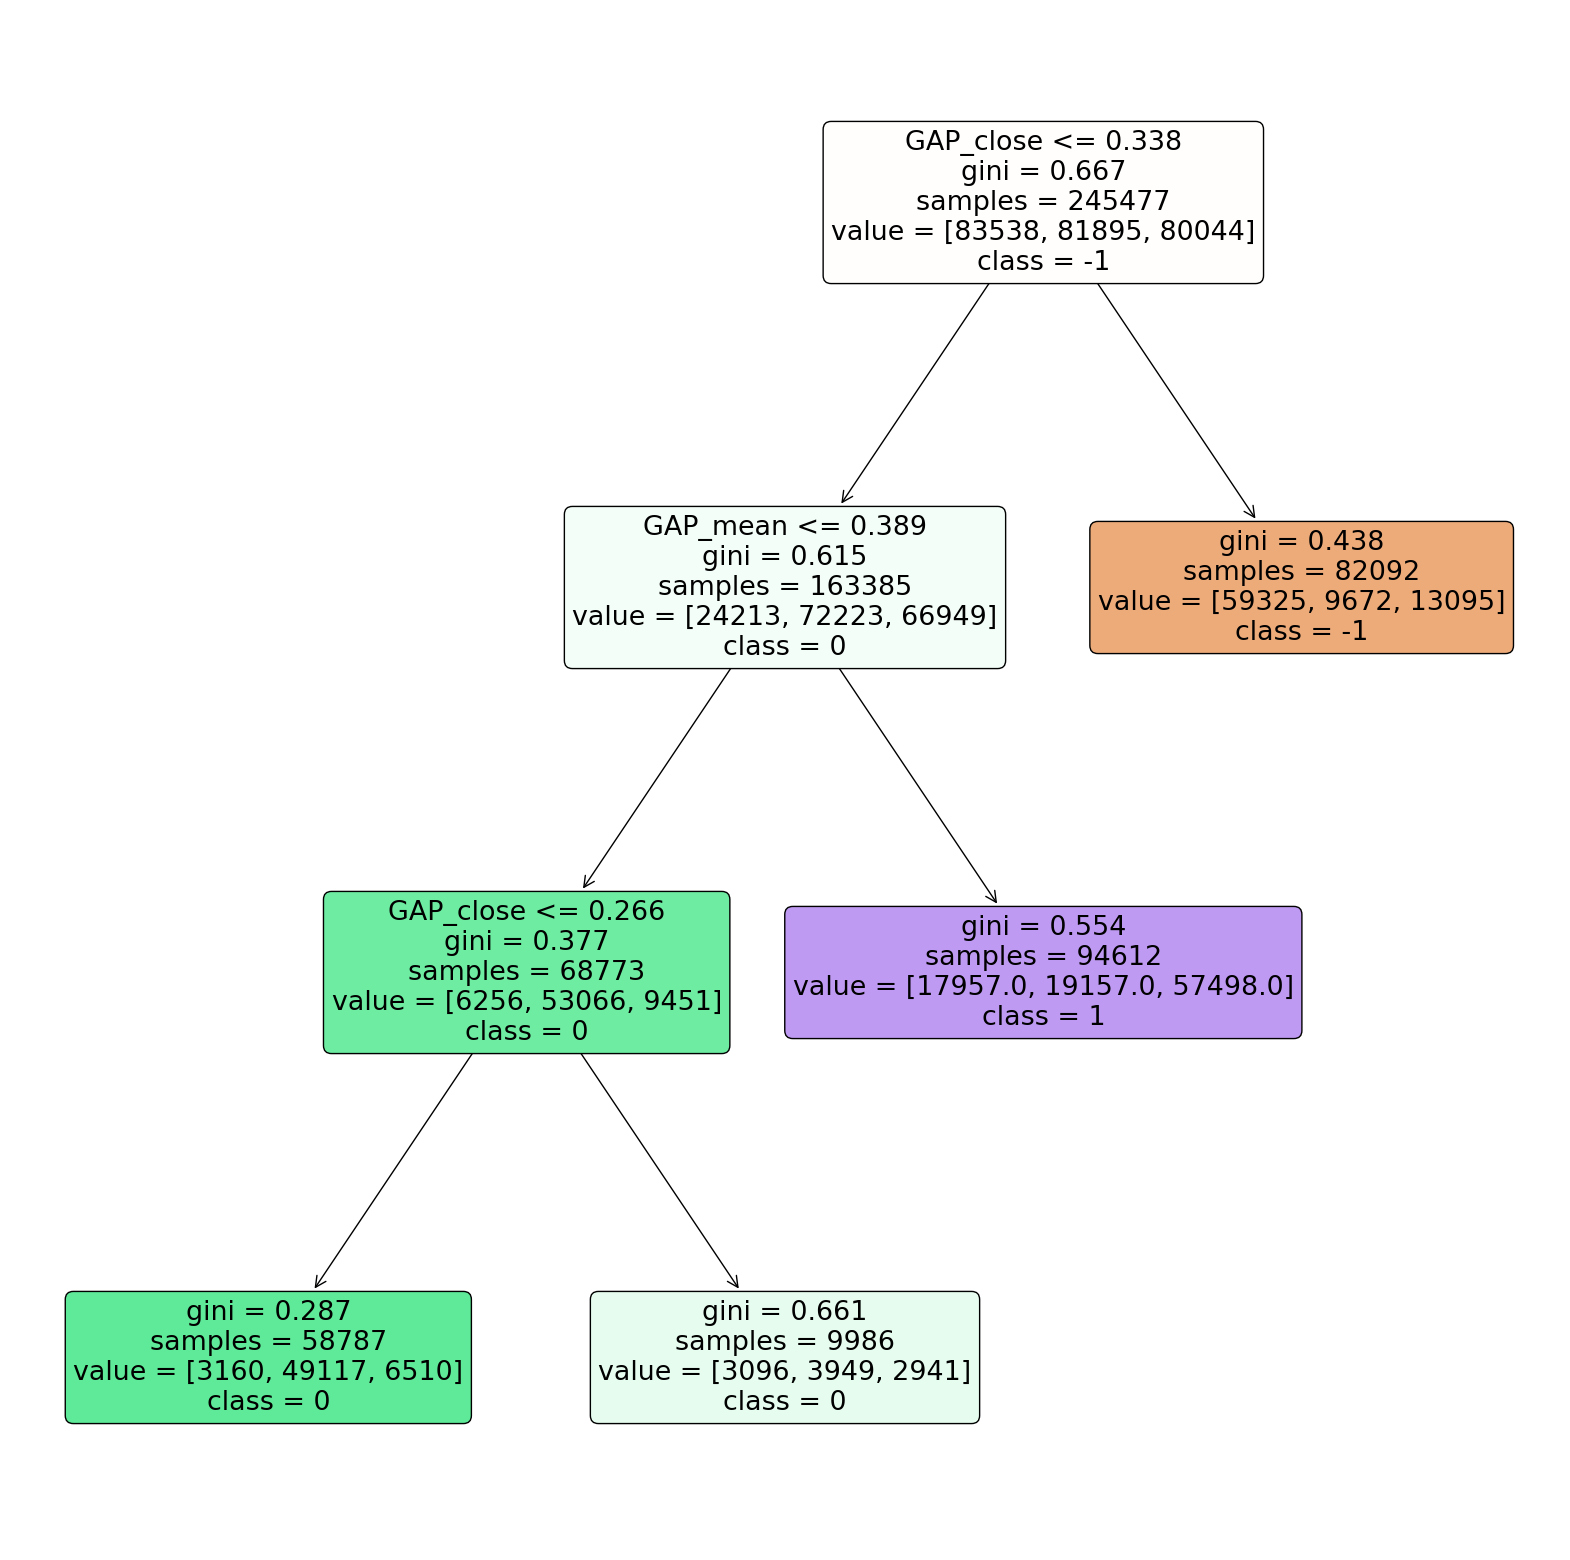

In [14]:
clf = DecisionTreeClassifier(max_leaf_nodes=4)
clf.fit(data[x_features],y_bool)

plt.figure(figsize=(20,5))
plt.bar(x_features, clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
plot_tree(clf, feature_names=x_features, class_names=[str(a) for a in clf.classes_], filled=True, rounded=True)
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

ypred = clf.predict(data[x_features])
ytrue = y_bool.to_numpy()
conf_matrix = confusion_matrix(ytrue, ypred, labels=clf.classes_)

for i, clas in enumerate(clf.classes_):
    print(f"Class {clas} Analysis...")
    
    print("Baseline =", np.mean(ytrue != clas))
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN
    
    print("TP =", TP)
    print("FP =", FP)
    print("TN =", TN)
    print("FN =", FN)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)
    print("Accuracy - Baseline =", ((TP + TN) / (TP + FP + TN + FN)) - np.mean(ytrue != clas))
    print()


Class -1 Analysis...
Baseline = 0.6596911319594096
TP = 59325
FP = 22767
TN = 139172
FN = 24213
Precision = 0.7226648150855138
Recall = 0.7101558572146808
F1 Score = 0.7163557326571274
Accuracy - Baseline = 0.14892637599449232

Class 0 Analysis...
Baseline = 0.6663842233691954
TP = 53066
FP = 15707
TN = 147875
FN = 28829
Precision = 0.771610951972431
Recall = 0.647976066914952
F1 Score = 0.7044096954894203
Accuracy - Baseline = 0.1521894108205657

Class 1 Analysis...
Baseline = 0.6739246446713949
TP = 57498
FP = 37114
TN = 128319
FN = 22546
Precision = 0.6077241787511098
Recall = 0.7183299185448003
F1 Score = 0.6584142543056065
Accuracy - Baseline = 0.08303832945652745



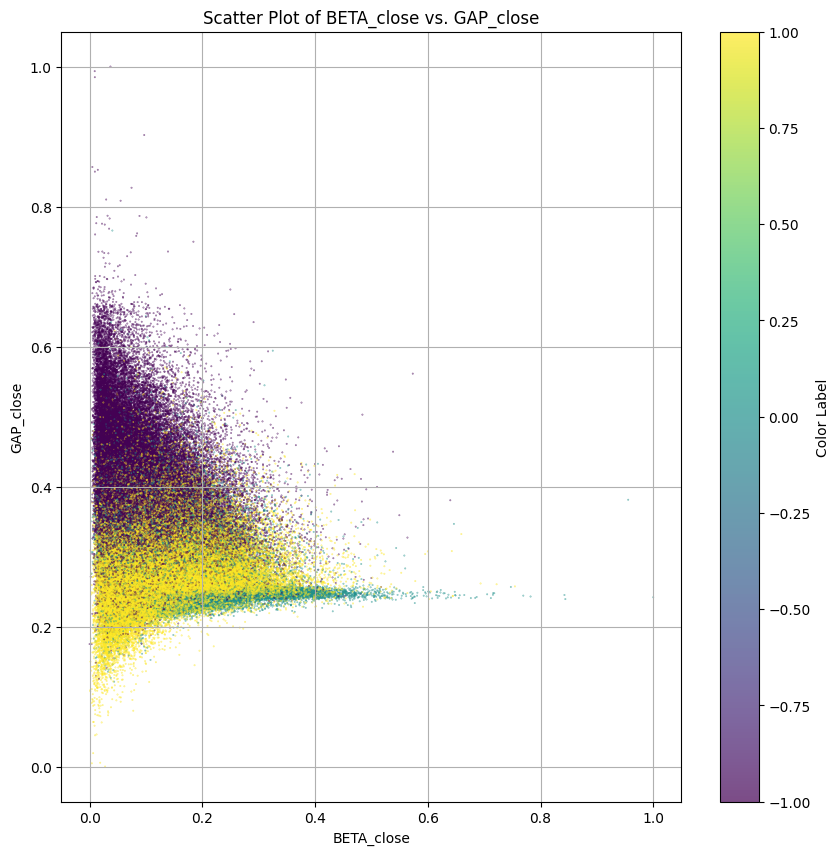

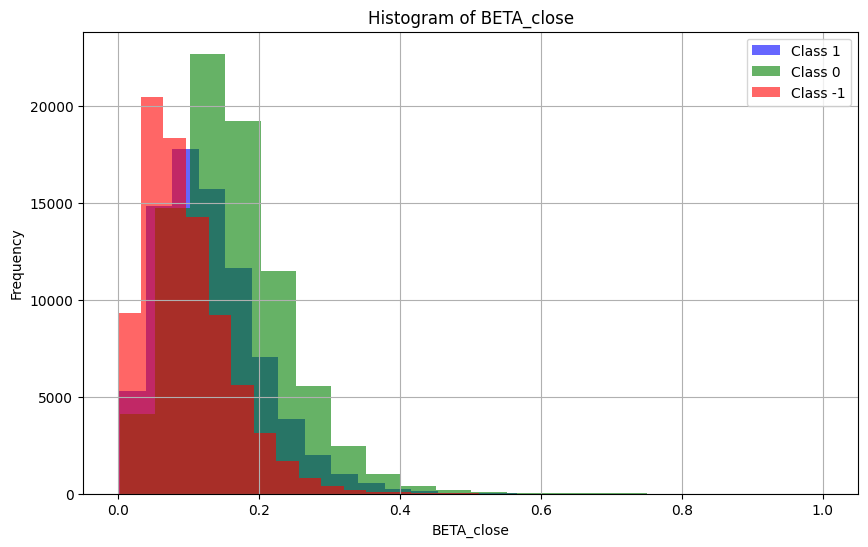

In [17]:
x_feat = "BETA_close" # most important features
y_feat = "GAP_close" # 2nd most important / interesting feature

plt.figure(figsize=(10, 10))
plt.scatter(data[x_feat], data[y_feat], s=1/2**3, c=y_bool, alpha=0.7, marker='o')
plt.colorbar(label='Color Label')
plt.xlabel(x_feat)
plt.ylabel(y_feat)
plt.title(f'Scatter Plot of {x_feat} vs. {y_feat}')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data[y_bool == 1][x_feat], bins=20, alpha=0.6, label="Class 1", color='blue')
plt.hist(data[y_bool == 0][x_feat], bins=20, alpha=0.6, label="Class 0", color='green')
plt.hist(data[y_bool == -1][x_feat], bins=20, alpha=0.6, label="Class -1", color='red')
plt.legend()
plt.xlabel(x_feat)
plt.ylabel('Frequency')
plt.title(f'Histogram of {x_feat}')
plt.grid(True)
plt.show()

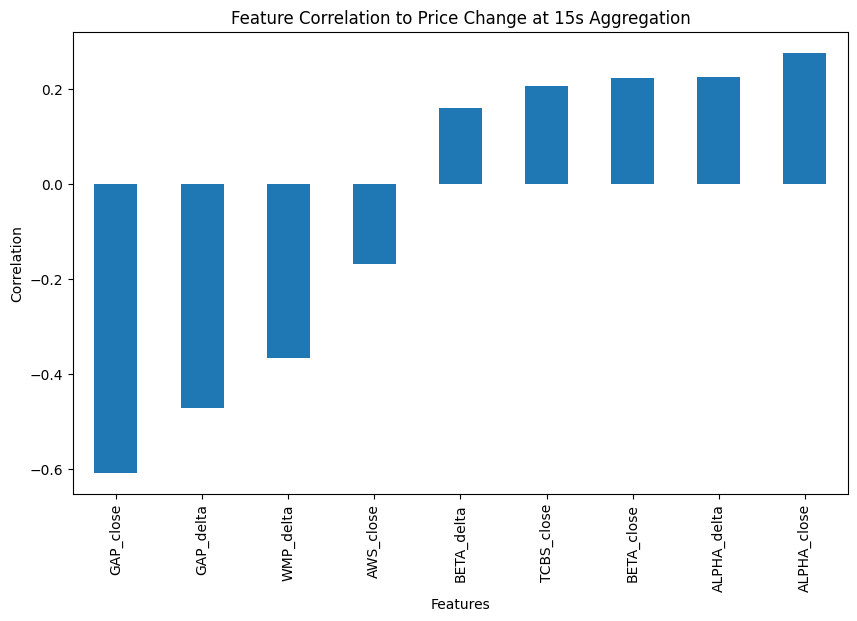

In [17]:
import matplotlib.pyplot as plt

# Define the mask for correlation values greater than 0.15 in absolute terms
mask = abs(corr_map[corr_map.index != "MP_perc(y)"]["MP_perc(y)"]) > 0.15

# Filter the correlation map based on the mask and plot the resulting series as a bar plot
corr_map[(corr_map.index != "MP_perc(y)")][mask]["MP_perc(y)"].sort_values().plot(kind="bar", figsize=(10, 6))

# Add title and labels to the plot
plt.title("Feature Correlation to Price Change at 15s Aggregation")
plt.xlabel("Features")
plt.ylabel("Correlation")

# Show the plot
plt.show()


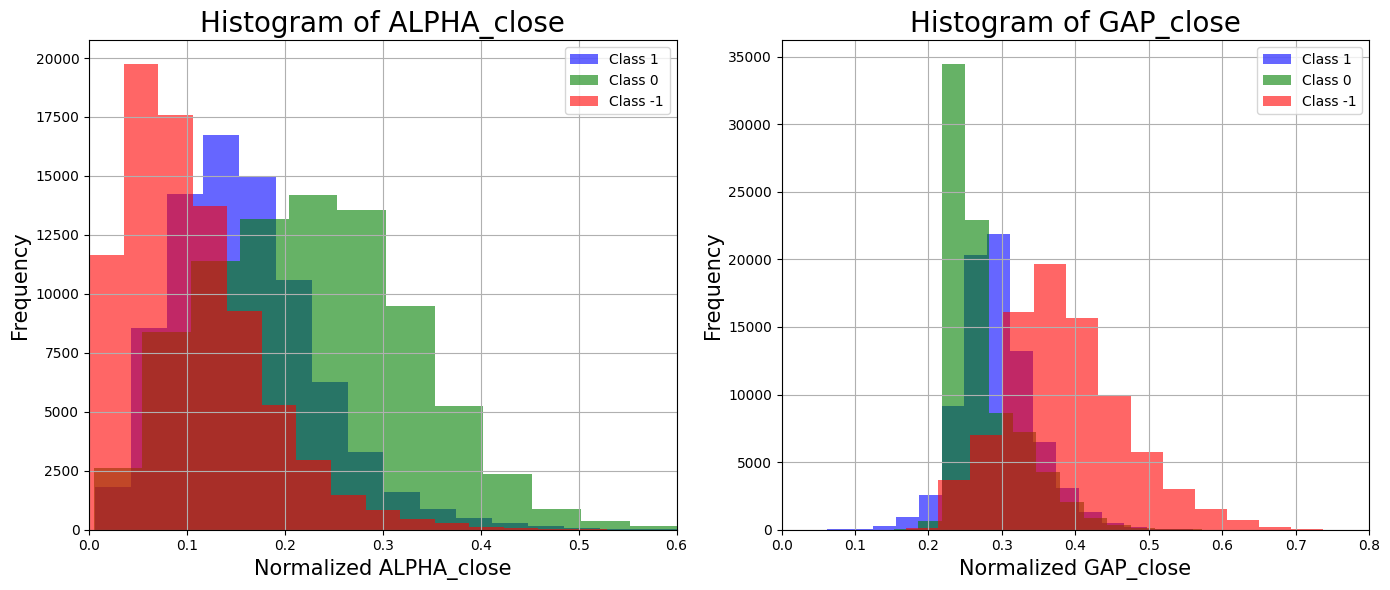

In [18]:
hist_feat_1 = "ALPHA_close"
hist_feat_2 = "GAP_close"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot histogram for hist_feat_1
axes[0].hist(data[y_bool == 1][hist_feat_1], bins=20, alpha=0.6, label="Class 1", color='blue')
axes[0].hist(data[y_bool == 0][hist_feat_1], bins=20, alpha=0.6, label="Class 0", color='green')
axes[0].hist(data[y_bool == -1][hist_feat_1], bins=20, alpha=0.6, label="Class -1", color='red')
axes[0].legend()
axes[0].set_xlabel("Normalized " + hist_feat_1, fontsize=15)
axes[0].set_ylabel('Frequency', fontsize=15)
axes[0].set_title(f'Histogram of {hist_feat_1}', fontsize=20)
axes[0].grid(True)
axes[0].set_xlim(0, 0.6)

# Plot histogram for hist_feat_2
axes[1].hist(data[y_bool == 1][hist_feat_2], bins=20, alpha=0.6, label="Class 1", color='blue')
axes[1].hist(data[y_bool == 0][hist_feat_2], bins=20, alpha=0.6, label="Class 0", color='green')
axes[1].hist(data[y_bool == -1][hist_feat_2], bins=20, alpha=0.6, label="Class -1", color='red')
axes[1].legend()
axes[1].set_xlabel("Normalized " + hist_feat_2, fontsize=15)
axes[1].set_ylabel('Frequency', fontsize=15)
axes[1].set_title(f'Histogram of {hist_feat_2}', fontsize=20)
axes[1].grid(True)
axes[1].set_xlim(0, 0.8)

plt.tight_layout()
plt.show()


In [21]:
raw_data = pd.read_csv("final_merged_15.csv", index_col=0)


In [23]:
gap_close_func = lambda x : (x * (raw_data["GAP_close"].max() - raw_data["GAP_close"].min())) + raw_data["GAP_close"].min()
gap_mean_func = lambda x : (x * (raw_data["GAP_mean"].max() - raw_data["GAP_mean"].min())) + raw_data["GAP_mean"].min()

print(gap_close_func(0.338))
gap_mean_func(0.389)

44.379716058102275


15.166085548137245

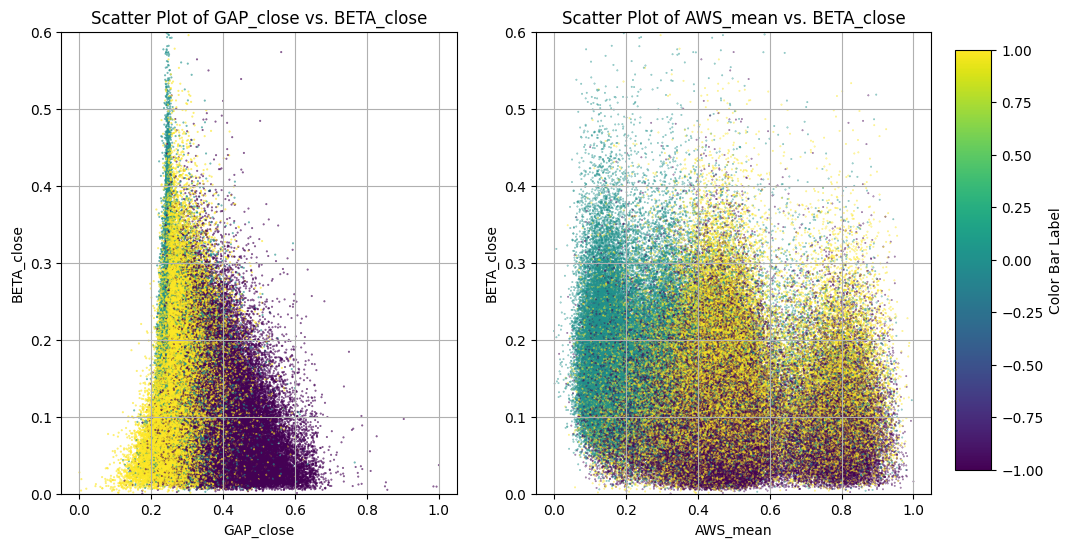

In [35]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Define data
x_feat_1 = "GAP_close"  # most important feature for the first plot
y_feat_1 = "BETA_close"    # 2nd most important/interesting feature for the first plot

x_feat_2 = "AWS_mean"  # most important feature for the second plot
y_feat_2 = "BETA_close"    # 2nd most important/interesting feature for the second plot

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Increased width to accommodate color bar

# Plot 1: Scatter Plot of x_feat_1 vs. y_feat_1
scatter1 = axs[0].scatter(data[x_feat_1], data[y_feat_1], s=1/2**2, c=y_bool, alpha=0.7, marker='o')
axs[0].set_xlabel(x_feat_1)
axs[0].set_ylabel(y_feat_1)
axs[0].set_title(f'Scatter Plot of {x_feat_1} vs. {y_feat_1}')
axs[0].grid(True)
axs[0].set_ylim(0, 0.6)  # Limit y-axis between 0 and 0.6

# Plot 2: Scatter Plot of x_feat_2 vs. y_feat_2
scatter2 = axs[1].scatter(data[x_feat_2], data[y_feat_2], s=1/2**3, c=y_bool, alpha=0.7, marker='o')
axs[1].set_xlabel(x_feat_2)
axs[1].set_ylabel(y_feat_2)
axs[1].set_title(f'Scatter Plot of {x_feat_2} vs. {y_feat_2}')
axs[1].grid(True)
axs[1].set_ylim(0, 0.6)  # Limit y-axis between 0 and 0.6

# Adjust layout
plt.subplots_adjust(right=0.85)  # Adjust the right margin to make space for color bar
cbar2_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Define position for color bar
cbar2 = plt.colorbar(ScalarMappable(norm=scatter2.norm, cmap=scatter2.cmap), cax=cbar2_ax)
cbar2.set_label('Color Bar Label')

# Show the plots
plt.show()
